In [1]:
import pandas as pd
import yfinance as yf
df = yf.download("RELIANCE.BO", start = '2019-12-01', end = '2021-03-25')
print(df)
import matplotlib.pyplot as plt
import numpy as np

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-12-02  1595.000000  1614.000000  1577.699951  1586.300049  1580.367065   
2019-12-03  1591.000000  1593.349976  1573.099976  1578.849976  1572.944824   
2019-12-04  1570.250000  1577.050049  1533.449951  1552.550049  1546.743286   
2019-12-05  1579.000000  1579.849976  1544.000000  1550.300049  1544.501709   
2019-12-06  1558.000000  1568.199951  1541.400024  1554.949951  1549.134277   
...                 ...          ...          ...          ...          ...   
2021-03-18  2071.100098  2085.000000  2001.000000  2009.500000  2009.500000   
2021-03-19  1988.300049  2095.000000  1981.199951  2081.899902  2081.899902   
2021-03-22  2075.000000  2075.000000  2033.900024  2061.850098  2061.850098   
2021-03-23  2064.000000  2109.899902  2057.250000  2089.050049

In [3]:
pivotpoints = []
dates = []
nature = []
for i in range(1, len(df['Open'])-1):
    current_price = df['Open'][i]
    prev_price = df['Open'][i-1]
    next_price = df['Open'][i+1]
    if (current_price - prev_price)>0 and (next_price - current_price)<0:
        pivotpoints.append(current_price)
        dates.append(df.index[i])
        nature.append('resistance')
    elif (current_price - prev_price)<0 and (next_price - current_price)>0:
        pivotpoints.append(current_price)
        dates.append(df.index[i])
        nature.append('support')
df_pp = pd.DataFrame(list(zip(pivotpoints, dates, nature)), columns = ['Pivot Point', 'Date/Time', 'Nature'])

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
def index_finder(date):
    for i in range(len(df.index)):
        if df.index[i]==date:
            return i

In [5]:
plot_dates = []
plot_pp = []
plot_nature = []
start = 0
for i in range(len(df_pp['Date/Time'])):
    end = index_finder(df_pp['Date/Time'][i])
    for j in range(start, end+1):
        plot_dates.append(df.index[j])
        plot_pp.append(df_pp['Pivot Point'][i])
        plot_nature.append(df_pp['Nature'][i])
        start = end
df_plot = pd.DataFrame(list(zip(plot_dates, plot_pp, plot_nature)), columns = ['Date/Time','Pivot Point', 'Nature'])
plt.show()
plot_strength = []
for i in range(len(df_plot['Pivot Point'])):
    price = df_plot['Pivot Point'][i]
    plot_strength.append(df_plot['Pivot Point'].tolist().count(price))
df_plot['Strength'] = plot_strength
min_str = np.mean(plot_strength)

In [6]:
import warnings
warnings.filterwarnings("ignore")

filler_pp = df_plot['Pivot Point'][0]
filler_str = df_plot['Strength'][0]
filler_nat = df_plot['Nature'][0]
for i in range(len(df_plot['Pivot Point'])):
    price = df_plot['Pivot Point'][i]
    strength = df_plot['Strength'][i]
    nature = df_plot['Nature'][i]
    if df_plot['Strength'][i]<min_str:
        df_plot['Pivot Point'][i] = filler_pp
        df_plot['Strength'][i] = filler_str
        df_plot['Nature'][i] = filler_nat
    else:
        filler_pp = price
        filler_str = strength
        filler_nat = nature
        
df_plot_res = df_plot[df_plot['Nature']=='resistance']
df_plot_sup = df_plot[df_plot['Nature']=='support']

In [7]:
def bool_check(li):
    for i in li:
        if i==True:
            return True
    return False

In [8]:
from datetime import date, timedelta
import numpy as np
import calendar
df_plot_res['Date/Time'] = pd.to_datetime(df_plot_res['Date/Time'])
df_plot_sup['Date/Time'] = pd.to_datetime(df_plot_sup['Date/Time'])

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2020, 12, 1)
end_date = date(2021, 3, 25)

for single_date in daterange(start_date, end_date):
    if bool_check(pd.Timestamp(single_date) == df_plot_res['Date/Time']) == False:
        df_plot_res = df_plot_res.append({'Date/Time': pd.Timestamp(single_date)}, ignore_index = True)
df_plot_res = df_plot_res.sort_values(by=['Date/Time'])

for single_date in daterange(start_date, end_date):
    if bool_check(pd.Timestamp(single_date) == df_plot_sup['Date/Time']) == False:
        df_plot_sup = df_plot_sup.append({'Date/Time': pd.Timestamp(single_date)}, ignore_index = True)
df_plot_sup = df_plot_sup.sort_values(by=['Date/Time'])
        
df_plot_res['Pivot Point'] = df_plot_res['Pivot Point'].fillna(method='ffill')
df_plot_sup['Pivot Point'] = df_plot_sup['Pivot Point'].fillna(method='ffill')

df_plot_res = df_plot_res.reset_index()
df_plot_sup = df_plot_sup.fillna(method = 'bfill')
new = np.array(df_plot_res['Pivot Point'])
for price in df_plot_res['Pivot Point'].unique():
    index = np.where(new == price)[0][0]
    df_plot_res['Pivot Point'][index] = np.nan

df_plot_sup = df_plot_sup.reset_index()
df_plot_sup = df_plot_sup.fillna(method = 'bfill')
new2 = np.array(df_plot_sup["Pivot Point"])
for price in df_plot_sup['Pivot Point'].unique():
    index = np.where(new2 == price)[0][0]
    df_plot_sup['Pivot Point'][index] = np.nan

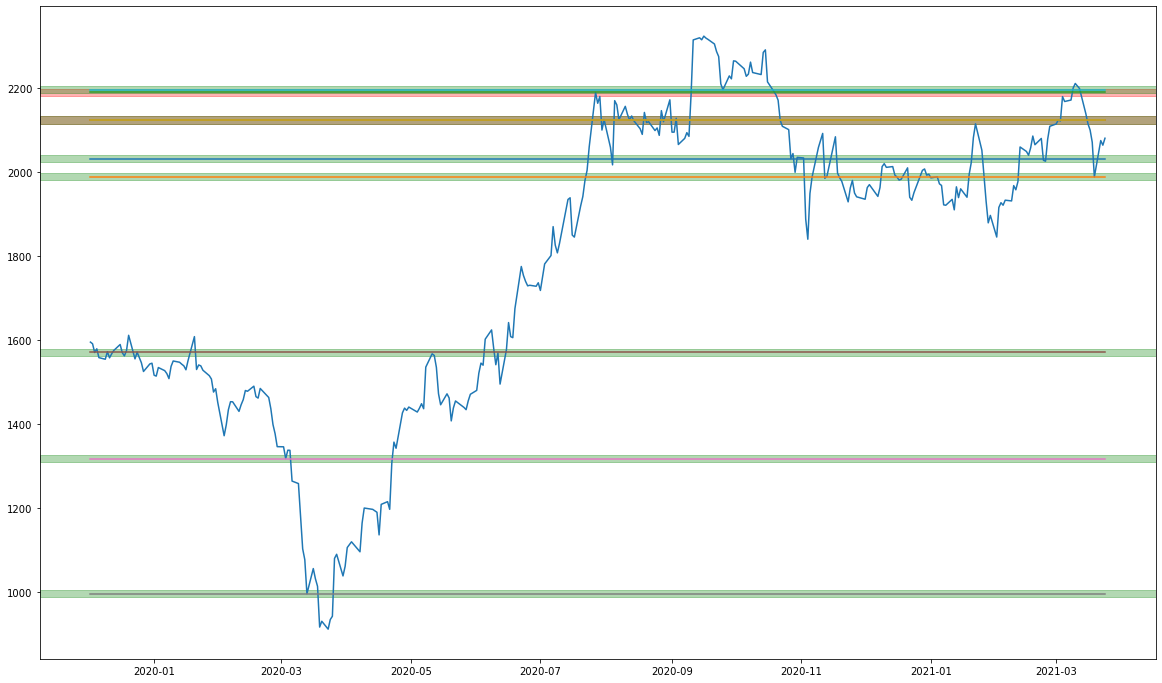

In [9]:
plt.rcParams["figure.figsize"] = (20,12)
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.plot(df.index, df.Open)
x = df.index
w = 0.005*np.mean(df_plot['Pivot Point'])
for price in df_plot_res['Pivot Point'].unique():
    y = []
    if price!=np.nan:
        for j in range(len(df.index)):
            y.append(price)
    ax.plot(x,y)
    ax.axhspan(price-w, price+w, color = 'red', alpha = 0.3)
for price in df_plot_sup['Pivot Point'].unique():
    y = []
    if price!=np.nan:
        for j in range(len(df.index)):
            y.append(price)
    ax.plot(x,y)
    ax.axhspan(price-w, price+w, color = 'green', alpha = 0.3)
#ax.plot(df_plot_res['Date/Time'], df_plot_res['Pivot Point'], c='r', label='resistance', linewidth=w, alpha = 0.5)
#ax.plot(df_plot_sup['Date/Time'], df_plot_sup['Pivot Point'], c='g', label='support', linewidth=w, alpha = 0.5)